# Drawception Reactions

This Notebook will create models to predict the number of reactions a Drawception image will recieve. There are 5 reactions an image can recieve and each one will need a different model. I will also make a prediction model of total reactions an image recieves.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils

import os
import PIL
import PIL.Image

In [2]:
# Grab the data
drawception = pd.read_csv('drawception_master.csv')

In [3]:
# Add a total reactions feature
drawception['REACT'] = drawception['LIKE']+drawception['HAHA']+drawception['WOW']+drawception['LOVE']+drawception['DUCK']

# Add image path column
drawception['img_path'] = ['/'.join(drawception.iloc[index,2].split('/')[3:6]) for index in range(len(drawception))]

In [4]:
drawception.head(3)

,pre_caption,post_caption,image_url,author,panel_number,LIKE,HAHA,WOW,LOVE,DUCK,game_url,player_num,game_date,game_tags,REACT,img_path
0,Guitar,brown guitar,https://cdn.drawception.com/drawings/1032692/1...,Alexyeaheyaha,2,0,0,0,0,0,/game/YC8aMef8Ox/guitar/,12,"December 18th, 2020",['blitz mode'],0,drawings/1032692/1KqoCkwSjF.png
1,brown guitar,Guitar,https://cdn.drawception.com/drawings/1041492/c...,celemon,4,0,0,0,0,0,/game/YC8aMef8Ox/guitar/,12,"December 18th, 2020",['blitz mode'],0,drawings/1041492/ct5kbWktZ9.png
2,Guitar,acoustic guitar,https://cdn.drawception.com/drawings/681336/dz...,Sarramiah and Daughter,6,0,0,0,0,0,/game/YC8aMef8Ox/guitar/,12,"December 18th, 2020",['blitz mode'],0,drawings/681336/dzq8daFSvo.png


### Create Dataset Generator

In [5]:
# Generator assistance provided by wiki.python.org

# The iloc call is looking for img_path and is using 15 for that index right now
def image_batch_gen(dataframe, batch_size, end):   
    count = 0
    while(1):
        image_batch = np.empty((batch_size, 250, 300, 3))
        label_batch = np.empty(batch_size)
        
        for i in range(batch_size):
            my_image = PIL.Image.open(dataframe.iloc[count,15])
            my_image = my_image.reduce(2)
            
            image_batch[i,:,:,:] = np.asarray(my_image)
            label_batch[i] = drawception.iloc[count, 14]
            
            count += 1
            if count < end:
                count = 0
        yield image_batch, label_batch        

In [6]:
# Train Test Split the DF
# thanks to Andy Hayden on stack exchange
split = np.random.rand(len(drawception)) < 0.8

train_df = drawception[split]
test_df = drawception[~split]

y_train = train_df['REACT']
y_test = test_df['REACT']

In [7]:
# Check that the data is split
print(train_df.shape, '  ', len(y_train))
print(test_df.shape, '  ', len(y_test))

(30308, 16)    30308
(7750, 16)    7750


In [16]:
cnn_model = Sequential()

# Add a convolutional layer.
cnn_model.add(Conv2D(
            filters=128,  # number of filters
            kernel_size=(3, 3),    # height/width of filter
            activation = 'relu',    # activation function 
            input_shape = (250, 300, 3))) # shape of input (image)

cnn_model.add(MaxPooling2D
             (pool_size=(2,2))) # dimensions of the region of pooling

cnn_model.add(Conv2D(filters = 128,
                    kernel_size = (3,3),
                    activation = 'relu'))

cnn_model.add(MaxPooling2D
             (pool_size=(2,2))) # dimensions of the region of pooling


cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3,3),
                    activation = 'relu'))

cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3,3),
                    activation = 'relu'))

cnn_model.add(MaxPooling2D
             (pool_size=(2,2))) # dimensions of the region of pooling

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))

cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(16, activation='relu'))

cnn_model.add(Dense(1, activation='linear'))

In [17]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 248, 298, 128)     3584      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 124, 149, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 122, 147, 128)     147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 61, 73, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 59, 71, 64)        73792     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 57, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 34, 64)       

In [18]:
# Compile model
cnn_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])

In [19]:

data_len = train_df.shape[0]
my_batch_size = 8

history = cnn_model.fit_generator(image_batch_gen(train_df, my_batch_size, data_len),
                                  steps_per_epoch=data_len//my_batch_size,
                                  epochs=10,
                                  verbose=1)

Epoch 1/10
3788/3788 [==============================] - 5358s 1s/step - loss: 44.6536 - mae: 0.1838
Epoch 2/10
3788/3788 [==============================] - 5052s 1s/step - loss: 4.8512e-07 - mae: 5.5409e-04
Epoch 3/10
3788/3788 [==============================] - 5036s 1s/step - loss: 1.7703e-08 - mae: 5.8933e-05
Epoch 4/10
3788/3788 [==============================] - 5087s 1s/step - loss: 1.3521e-11 - mae: 7.4376e-07
Epoch 5/10
3788/3788 [==============================] - 5083s 1s/step - loss: 1.8514e-14 - mae: 2.0649e-08
Epoch 6/10
3788/3788 [==============================] - 5106s 1s/step - loss: 1.4594e-23 - mae: 1.7060e-12
Epoch 7/10
3788/3788 [==============================] - 30477s 8s/step - loss: 7.1217e-10 - mae: 6.7091e-06
Epoch 8/10
3788/3788 [==============================] - 5075s 1s/step - loss: 7.3813e-10 - mae: 6.9565e-06
Epoch 9/10
3788/3788 [==============================] - 5110s 1s/step - loss: 7.8813e-10 - mae: 7.5446e-06
Epoch 10/10
3788/3788 [====================

In [ ]:
testing = PIL.Image.open(drawception.iloc[12345,15])
testing = testing.reduce(4)
#testing[1,:,:,:] = np.asarray(testing)
my_image = np.empty((1, 125, 150, 3))
my_image[0,:,:,:] = np.asarray(testing)

my_image.shape
#drawception.iloc[2375,14]

In [ ]:
drawception.iloc[12345,14]

In [ ]:
cnn_model.predict(my_image)

In [20]:
# The iloc call is looking for img_path and is using 15 for that index right now
def test_batch(dataframe, size):   
    
    image_batch = np.empty((size, 250, 300, 3))
    for i in range(size):
        my_image = PIL.Image.open(dataframe.iloc[i,15])
        my_image = my_image.reduce(2)
            
        image_batch[i,:,:,:] = np.asarray(my_image)
            
    return image_batch

In [26]:
X_test = test_batch(test_df, 100)

In [27]:
X_test.shape

(100, 250, 300, 3)

In [28]:
preds = cnn_model.predict(X_test)

In [29]:
y_true = test_df['REACT'].head(100)

In [30]:
y_true.shape

(100,)

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(y_true, preds)

-0.8371321734390911

In [ ]:
y_true[:10]

In [ ]:
test_df['preds'] = preds

In [ ]:
test_df.sort_values(by='REACT', ascending=True).head(20)

In [ ]:
PIL.Image.open(test_df[test_df.index == 17800]['img_path'].item())

In [ ]:
test_df['preds'].plot(kind='hist', bins=100)

In [ ]:
test_df['REACT'].plot(kind='hist', bins=100)

In [54]:
def predict_batch(dataframe, model):   
    
    output = []
    
    image_dat = np.empty((1, 250, 300, 3))
    for i in range(dataframe.shape[0]):
        my_image = PIL.Image.open(dataframe.iloc[i,15])
        my_image = my_image.reduce(2)
            
        image_dat[0,:,:,:] = np.asarray(my_image)
        pred = model.predict(image_dat)
        
        img_dic = {}
        img_dic['y_pred'] = pred.item()
        img_dic['y_true'] = dataframe.iloc[i,14]
        
        output.append(img_dic)
            
    return output

In [55]:
prediction_list = predict_batch(test_df, cnn_model)

In [56]:
len(prediction_list)

7750

In [50]:
test_df.shape

(7750, 16)

In [57]:
pred_df = pd.DataFrame(prediction_list)
pred_df.head()

,y_pred,y_true
0,-2.357639e-12,0
1,1.072601e-02,0
2,-2.357639e-12,1
3,-5.551826e-03,1
4,-5.396612e-01,1


<AxesSubplot:ylabel='Frequency'>

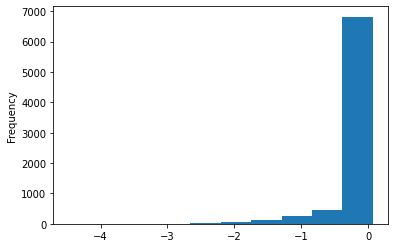

In [58]:
pred_df['y_pred'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

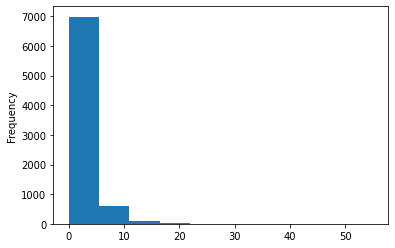

In [59]:
pred_df['y_true'].plot(kind='hist')

In [60]:
r2_score(pred_df['y_true'], pred_df['y_pred'])

-0.664350530734745

In [61]:
pred_df.to_csv('prediction.csv', index=False)